# Digit Recognizer

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

## Get helper functions and import libraries

I've stored some functions helpful for data analysis on GitHub. Credit to Daniel Bourke for many of them, check out his course on Zero to Mastery!

In [ ]:
# Get helper functions
import os.path
!wget https://raw.githubusercontent.com/ryanmalley101/Inara/main/helper_functions.py

--2023-01-06 04:27:46--  https://raw.githubusercontent.com/ryanmalley101/Inara/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4494 (4.4K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]   4.39K  --.-KB/s    in 0s      

2023-01-06 04:27:46 (65.9 MB/s) - ‘helper_functions.py.1’ saved [4494/4494]



In [ ]:
from helper_functions import *
from google.colab import files
import tensorflow as tf
import numpy as np
import pandas as pd
import zipfile

## Explore Datasets


Download and Unzip Data

In [ ]:
!pip install -q kaggle

!mkdir ~/.kaggle
!cp /content/drive/MyDrive/datasets/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c digit-recognizer


mkdir: cannot create directory ‘/root/.kaggle’: File exists
digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip
unzip_data("/content/digit-recognizer.zip")

Get Data into DataFrames

In [ ]:
train_csv = "/content/train.csv"
test_csv = "/content/test.csv"

# Read the csvs into a dataframe
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)


# Extract the labels from the training dataframe
train_labels_df = train_df["label"]
train_labels_df.head()

# Drop the labels column from the training dataframe
train_df = train_df.drop("label", axis=1)
train_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


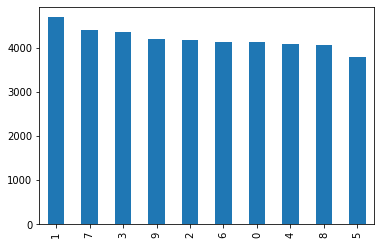

In [ ]:
# Plot number of each class in training set
train_labels_df.value_counts().plot(kind="bar")

Visualizing this is pretty much as possible seems almost impossible. Dataframes aren't going to be helpful here

In [ ]:
# Transform the dataframes to numpy arrays so they can be reshapes
train_np = train_df.to_numpy()
test_np = test_df.to_numpy()
train_np

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Iterate through np array and reshape the 1D arrays to 2D image tensors
train_2d = []
for x in train_np:
  train_2d.append(x.reshape(28, 28))
train_2d[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 188, 255,  94,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 191, 250, 253,  93,   0,   0,   0,
          0,   0],
       [  

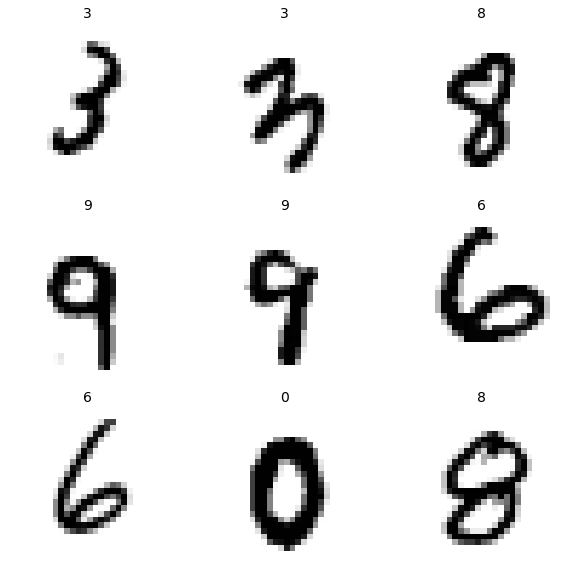

In [ ]:
show_nine_images(train_2d, train_labels_df)

### Create train and val splits directly from the pandas dataframes (to preserve one dimensional data)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_df.to_numpy(), train_labels_df.to_numpy(), test_size=0.2, random_state=42)
x_train = tf.expand_dims(x_train, axis=-1)
x_val = tf.expand_dims(x_val, axis=-1)
len(x_train), len(y_train), len(x_val), len(y_val)

(33600, 33600, 8400, 8400)

In [ ]:
pd.DataFrame(y_train)[0]

0        6
1        5
2        3
3        4
4        7
        ..
33595    9
33596    9
33597    2
33598    6
33599    0
Name: 0, Length: 33600, dtype: int64

In [ ]:
# One-Hot Encode Labels
y_train_one_hot = pd.get_dummies(pd.DataFrame(y_train)[0]).to_numpy()
y_val_one_hot = pd.get_dummies(pd.DataFrame(y_val)[0]).to_numpy()

In [ ]:
# Turn numpy arrays into tensorflow Datasets
train_ds_unoptimized = tf.data.Dataset.from_tensor_slices((x_train, y_train_one_hot))
val_ds_unoptimized = tf.data.Dataset.from_tensor_slices((x_val, y_val_one_hot))
train_ds = train_ds_unoptimized.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds_unoptimized.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(32, 784, 1), dtype=tf.int64, name=None), TensorSpec(shape=(32, 10), dtype=tf.uint8, name=None))>

## Start modelling experiments

1. Baseline (SVC Classifier as per https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
2. Simple Dense Model (Two hidden layers, 10 neurons each)

### 1. Baseline SVC Classifier
Multiclass in this case with a "one-versus-one" approach

In [ ]:
from sklearn import svm
# Create SVC Classifier

model_0 = svm.SVC(decision_function_shape='ovo')
model_0.fit(tf.squeeze(x_train), y_train)

SVC(decision_function_shape='ovo')

In [ ]:
# How accurate is the SVC Classifier
model_0_results = model_0.score(tf.squeeze(x_val), y_val)
print(f"Baseline Accuracy: {model_0_results*100:.2f}%")

Baseline Accuracy: 97.35%


## 2. Simple Dense Model

We'll make a very basic Dense model with a normalization layer to get values from 0-255 to 0-1

In [ ]:
from tensorflow.keras import layers
# Set random seed
tf.random.set_seed(42)

# Create the model
model_1 = tf.keras.Sequential([
  layers.Rescaling(scale=1/255.),
  layers.Flatten(),
  layers.Dense(10, activation="relu"),
  layers.Dense(10, activation="softmax")
])

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_1.fit(train_ds,
            # batch_size=32,
            # steps_per_epoch = int(len(train_ds)//32),
            epochs=100,
            validation_data=val_ds,
            # validation_steps = int(len(val_ds)//32),
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)])

Epoch 1/100
1050/1050 [==============================] - 7s 3ms/step - loss: 0.6567 - accuracy: 0.8084 - val_loss: 0.3556 - val_accuracy: 0.9011
Epoch 2/100
1050/1050 [==============================] - 3s 3ms/step - loss: 0.3112 - accuracy: 0.9107 - val_loss: 0.3067 - val_accuracy: 0.9138
Epoch 3/100
1050/1050 [==============================] - 3s 3ms/step - loss: 0.2745 - accuracy: 0.9213 - val_loss: 0.2862 - val_accuracy: 0.9188
Epoch 4/100
1050/1050 [==============================] - 9s 9ms/step - loss: 0.2539 - accuracy: 0.9277 - val_loss: 0.2745 - val_accuracy: 0.9224
Epoch 5/100
1050/1050 [==============================] - 6s 6ms/step - loss: 0.2395 - accuracy: 0.9325 - val_loss: 0.2675 - val_accuracy: 0.9253
Epoch 6/100
1050/1050 [==============================] - 3s 3ms/step - loss: 0.2285 - accuracy: 0.9363 - val_loss: 0.2619 - val_accuracy: 0.9269
Epoch 7/100
1050/1050 [==============================] - 3s 3ms/step - loss: 0.2196 - accuracy: 0.9387 - val_loss: 0.2581 - val_ac

In [ ]:
model_1_results = model_1.evaluate(val_ds)
model_1_results

262/262 [==============================] - 1s 2ms/step - loss: 0.2497 - accuracy: 0.9308


[0.2497483491897583, 0.9308205842971802]

## Model 3 : More Complex Dense Model
We'll add two more Dense layers to model 2 and increase the number of neurons to 16 per

In [ ]:
from tensorflow.keras import layers
# Set random seed
tf.random.set_seed(42)

# Create the model
model_2 = tf.keras.Sequential([
  layers.Rescaling(scale=1/255.),
  layers.Flatten(),
  layers.Dense(16, activation="relu"),
  layers.Dense(16, activation="relu"),
  layers.Dense(16, activation="relu"),
  layers.Dense(10, activation="softmax")
])

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_2.fit(train_ds,
            batch_size=32,
            # steps_per_epoch = int(len(train_ds)//32),
            epochs=100,
            validation_data=val_ds,
            # validation_steps = int(len(val_ds)//32),
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)])

Epoch 1/100
1050/1050 [==============================] - 5s 4ms/step - loss: 0.5803 - accuracy: 0.8233 - val_loss: 0.3227 - val_accuracy: 0.9054
Epoch 2/100
1050/1050 [==============================] - 5s 4ms/step - loss: 0.2679 - accuracy: 0.9227 - val_loss: 0.2699 - val_accuracy: 0.9181
Epoch 3/100
1050/1050 [==============================] - 4s 3ms/step - loss: 0.2207 - accuracy: 0.9367 - val_loss: 0.2473 - val_accuracy: 0.9260
Epoch 4/100
1050/1050 [==============================] - 4s 3ms/step - loss: 0.1944 - accuracy: 0.9446 - val_loss: 0.2343 - val_accuracy: 0.9308
Epoch 5/100
1050/1050 [==============================] - 4s 3ms/step - loss: 0.1751 - accuracy: 0.9499 - val_loss: 0.2268 - val_accuracy: 0.9334
Epoch 6/100
1050/1050 [==============================] - 4s 3ms/step - loss: 0.1608 - accuracy: 0.9536 - val_loss: 0.2205 - val_accuracy: 0.9371
Epoch 7/100
1050/1050 [==============================] - 4s 3ms/step - loss: 0.1493 - accuracy: 0.9563 - val_loss: 0.2168 - val_ac

In [ ]:
model_2_results = model_2.evaluate(val_ds)
model_2_results

262/262 [==============================] - 1s 2ms/step - loss: 0.2071 - accuracy: 0.9418


[0.20710110664367676, 0.9417939186096191]

In [ ]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(32, 784, 1), dtype=tf.int64, name=None), TensorSpec(shape=(32, 10), dtype=tf.uint8, name=None))>

## Model 4 - CNN

Create a model with convolutional layers

In [ ]:
from tensorflow.keras import layers
# Set random seed
tf.random.set_seed(42)

# Create the model
model_3 = tf.keras.Sequential([
  layers.Rescaling(scale=1/255.),
  layers.Conv1D(filters=8, kernel_size=3, activation="relu", name="conv_1"),
  layers.Conv1D(filters=8, kernel_size=3, activation="relu", name="conv_2"),
  layers.Flatten(),
  layers.Dense(10, activation="softmax")
])

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_3.fit(train_ds,
            # batch_size=32,
            # steps_per_epoch = int(len(train_ds)//32),
            epochs=100,
            validation_data=val_ds,
            # validation_steps = int(len(val_ds)//32),
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)])

Epoch 1/100
1050/1050 [==============================] - 7s 4ms/step - loss: 0.3184 - accuracy: 0.9091 - val_loss: 0.2009 - val_accuracy: 0.9414
Epoch 2/100
1050/1050 [==============================] - 4s 4ms/step - loss: 0.1668 - accuracy: 0.9511 - val_loss: 0.1692 - val_accuracy: 0.9470
Epoch 3/100
1050/1050 [==============================] - 4s 4ms/step - loss: 0.1356 - accuracy: 0.9601 - val_loss: 0.1611 - val_accuracy: 0.9495
Epoch 4/100
1050/1050 [==============================] - 4s 4ms/step - loss: 0.1168 - accuracy: 0.9658 - val_loss: 0.1581 - val_accuracy: 0.9518
Epoch 5/100
1050/1050 [==============================] - 4s 4ms/step - loss: 0.1029 - accuracy: 0.9703 - val_loss: 0.1591 - val_accuracy: 0.9530
Epoch 6/100
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0915 - accuracy: 0.9732 - val_loss: 0.1632 - val_accuracy: 0.9510
Epoch 7/100
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0815 - accuracy: 0.9765 - val_loss: 0.1699 - val_ac

In [ ]:
model_3_results = model_3.evaluate(val_ds)
model_3_results

262/262 [==============================] - 1s 3ms/step - loss: 0.1581 - accuracy: 0.9518


[0.1581019163131714, 0.9518129825592041]

## Model 5 - More complex CNN with Dropout and Max Pooling


In [ ]:

from tensorflow.keras import layers
# Set random seed
tf.random.set_seed(42)

# Create the model
model_4 = tf.keras.Sequential([
  layers.Rescaling(scale=1/255.),
  layers.Conv1D(10, 3, activation="relu"),
  layers.MaxPool1D(),
  layers.Dropout(0.3),
  layers.Conv1D(10, 3, activation="relu"),
  layers.MaxPool1D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation="relu"),
  layers.Dense(10, activation="softmax")
])

# Compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_4.fit(train_ds,
            # batch_size=32,
            # steps_per_epoch = int(len(train_ds)//32),
            epochs=100,
            validation_data=val_ds,
            # validation_steps = int(len(val_ds)//32),
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)])


Epoch 1/100
1050/1050 [==============================] - 7s 5ms/step - loss: 0.3333 - accuracy: 0.8960 - val_loss: 0.1491 - val_accuracy: 0.9536
Epoch 2/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.1518 - accuracy: 0.9519 - val_loss: 0.1085 - val_accuracy: 0.9661
Epoch 3/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.1159 - accuracy: 0.9628 - val_loss: 0.0967 - val_accuracy: 0.9673
Epoch 4/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0950 - accuracy: 0.9695 - val_loss: 0.0811 - val_accuracy: 0.9699
Epoch 5/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0804 - accuracy: 0.9741 - val_loss: 0.0840 - val_accuracy: 0.9703
Epoch 6/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0684 - accuracy: 0.9779 - val_loss: 0.0848 - val_accuracy: 0.9705
Epoch 7/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0606 - accuracy: 0.9804 - val_loss: 0.0669 - val_ac

In [ ]:
model_4_results = model_4.evaluate(val_ds)
model_4_results

262/262 [==============================] - 1s 3ms/step - loss: 0.0555 - accuracy: 0.9820


[0.05552900582551956, 0.9819895029067993]

## Model 6 : LSTM

In [ ]:
from tensorflow.keras import layers
# Set random seed
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(784, 1))
x = layers.Rescaling(scale=1/255.)(inputs)
# print(x.shape)
x = layers.LSTM(128, return_sequences=True, name="LSTM_1")(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, name="LSTM_2")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(10, activation="softmax")(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile the model
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_5.fit(train_ds,
            batch_size=32,
            steps_per_epoch = int(len(train_ds)//32),
            epochs=100,
            validation_data=val_ds,
            validation_steps = int(len(val_ds)//32),
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)])


Epoch 1/100
32/32 [==============================] - 12s 174ms/step - loss: 2.3032 - accuracy: 0.1074 - val_loss: 2.3040 - val_accuracy: 0.0781
Epoch 2/100
32/32 [==============================] - 2s 77ms/step - loss: 2.3026 - accuracy: 0.1094 - val_loss: 2.2963 - val_accuracy: 0.1289
Epoch 3/100
32/32 [==============================] - 2s 77ms/step - loss: 2.3079 - accuracy: 0.1182 - val_loss: 2.2940 - val_accuracy: 0.1211
Epoch 4/100
32/32 [==============================] - 2s 74ms/step - loss: 2.2992 - accuracy: 0.1133 - val_loss: 2.2532 - val_accuracy: 0.2344
Epoch 5/100
32/32 [==============================] - 2s 73ms/step - loss: 2.2075 - accuracy: 0.1338 - val_loss: 2.0112 - val_accuracy: 0.1953
Epoch 6/100
32/32 [==============================] - 2s 76ms/step - loss: 2.0421 - accuracy: 0.2383 - val_loss: 1.9259 - val_accuracy: 0.3477
Epoch 7/100
32/32 [==============================] - 2s 74ms/step - loss: 1.9415 - accuracy: 0.2842 - val_loss: 1.7886 - val_accuracy: 0.3516
Epoc

In [ ]:
model_5_results = model_5.evaluate(val_ds)
model_5_results

262/262 [==============================] - 8s 31ms/step - loss: 1.7039 - accuracy: 0.3542


[1.7039350271224976, 0.3542461693286896]

Well that sucked, LSTMs don't seem to be helping much

## Model 7 - Random Forests

This will be my first time creating a random forest model, let's see how it goes. Pulling the structure from: https://www.tensorflow.org/decision_forests/tutorials/beginner_colab

In [ ]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_decision_forests as tfdf

train_ds_categorical = tf.data.Dataset.from_tensor_slices((tf.squeeze(x_train), y_train))
val_ds_categorical = tf.data.Dataset.from_tensor_slices((tf.squeeze(x_val), y_val))
train_ds_large_batch = train_ds_categorical.batch(1000).prefetch(tf.data.AUTOTUNE)
val_ds_large_batch = val_ds_categorical.batch(1000).prefetch(tf.data.AUTOTUNE)


# Specify the model.
model_6 = tfdf.keras.RandomForestModel(verbose=2)

# Train the model.
model_6.fit(train_ds_large_batch,
            validation_data = val_ds_large_batch)

Use 2 thread(s) for training
Use /tmp/tmp6on3prrr as temporary training directory
Reading training dataset...
Training tensor examples:
Features: Tensor("data:0", shape=(None, 784), dtype=int64)
Label: Tensor("data_1:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'data:0.0': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice:0' shape=(None,) dtype=float32>), 'data:0.1': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_1:0' shape=(None,) dtype=float32>), 'data:0.2': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_2:0' shape=(None,) dtype=float32>), 'data:0.3': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_3:0' shape=(None,) dtype=float32>), 'data:0.4': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_4:0' shape=(None,) dtype=float32>), 'data:0.5': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>

[INFO 2023-01-06T04:56:06.388995478+00:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-01-06T04:56:06.389197887+00:00 kernel.cc:815] Collect training examples
[INFO 2023-01-06T04:56:06.391559655+00:00 kernel.cc:423] Number of batches: 34
[INFO 2023-01-06T04:56:06.391579827+00:00 kernel.cc:424] Number of examples: 33600
[INFO 2023-01-06T04:56:06.618041369+00:00 kernel.cc:837] Training dataset:
Number of records: 33600
Number of columns: 785

Number of columns by type:
	NUMERICAL: 784 (99.8726%)
	CATEGORICAL: 1 (0.127389%)

Columns:

NUMERICAL: 784 (99.8726%)
	0: "data:0.0" NUMERICAL mean:0 min:0 max:0 sd:0
	1: "data:0.1" NUMERICAL mean:0 min:0 max:0 sd:0
	2: "data:0.10" NUMERICAL mean:0 min:0 max:0 sd:0
	3: "data:0.100" NUMERICAL mean:13.2333 min:0 max:255 sd:50.272
	4: "data:0.101" NUMERICAL mean:11.7187 min:0 max:255 sd:47.4442
	5: "data:0.102" NUMERICAL mean:9.41554 min:0 max:255 sd:42.8245
	6: "data:0.103" NUMERICAL mean:6.77077 min:0 max:255 sd:36.38
	7: "data:0.104" NU

Model trained in 0:04:12.560275
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


I don't know how to fix the evaluation errors in this function. I'll take the output accuracy above at its word, ~96%

In [ ]:
model_6_results = [0.26379, 0.960982]

In [ ]:
## Evaluate model results
results = {"model_1_baseline": model_0_results,
           "model_2_dense_lite": model_1_results,
           "model_3_dense_large": model_2_results,
           "model_4_cnn_lite": model_3_results,
           "model_5_cnn_large": model_4_results,
           "model_6_lstm": model_5_results,
           "model_7_random_forest": model_6_results}

results_df = pd.DataFrame(results).transpose()
acc_df = results_df[1]
acc_df

model_1_baseline         0.973452
model_2_dense_lite       0.930821
model_3_dense_large      0.941794
model_4_cnn_lite         0.951813
model_5_cnn_large        0.981990
model_6_lstm             0.354246
model_7_random_forest    0.960982
Name: 1, dtype: float64

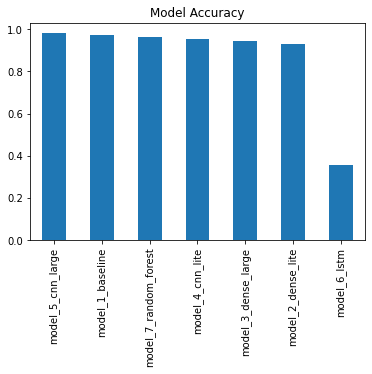

In [ ]:
acc_df.sort_values(ascending=False).plot(kind="bar", title="Model Accuracy")

So model 5 is our most accurate model, the only one to beat the baseline. Lets try and fine tune it.

## Fine Tuning


### Model 8 - Reduce Dropout

In [ ]:
# Reduce dropout percentages

from tensorflow.keras import layers
# Set random seed
tf.random.set_seed(42)

# Create the model
model_7 = tf.keras.Sequential([
  layers.Rescaling(scale=1/255.),
  layers.Conv1D(10, 3, activation="relu"),
  layers.MaxPool1D(),
  layers.Dropout(0.2),
  layers.Conv1D(10, 3, activation="relu"),
  layers.MaxPool1D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation="relu"),
  layers.Dense(10, activation="softmax")
])

# Compile the model
model_7.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_7.fit(train_ds,
            # batch_size=32,
            # steps_per_epoch = int(len(train_ds)//32),
            epochs=100,
            validation_data=val_ds,
            # validation_steps = int(len(val_ds)//32),
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=1)])


Epoch 1/100
1050/1050 [==============================] - 7s 5ms/step - loss: 0.3158 - accuracy: 0.9045 - val_loss: 0.1357 - val_accuracy: 0.9579 - lr: 0.0010
Epoch 2/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.1346 - accuracy: 0.9577 - val_loss: 0.1057 - val_accuracy: 0.9674 - lr: 0.0010
Epoch 3/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.1019 - accuracy: 0.9681 - val_loss: 0.0943 - val_accuracy: 0.9690 - lr: 0.0010
Epoch 4/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0778 - accuracy: 0.9754 - val_loss: 0.0970 - val_accuracy: 0.9689 - lr: 0.0010
Epoch 5/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0649 - accuracy: 0.9786 - val_loss: 0.0994 - val_accuracy: 0.9674 - lr: 0.0010
Epoch 6/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0528 - accuracy: 0.9831 - val_loss: 0.0896 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 7/100
1050/1050 [=============================

In [ ]:
model_7_results = model_7.evaluate(val_ds)
model_7_results

262/262 [==============================] - 1s 3ms/step - loss: 0.0619 - accuracy: 0.9844


[0.061893973499536514, 0.984375]

### Model 9 - Increase Convolution Units

In [ ]:
# Reduce dropout percentages

from tensorflow.keras import layers
# Set random seed
tf.random.set_seed(42)

# Create the model
model_8 = tf.keras.Sequential([
  layers.Rescaling(scale=1/255.),
  layers.Conv1D(32, 3, activation="relu"),
  layers.MaxPool1D(),
  layers.Dropout(0.3),
  layers.Conv1D(16, 3, activation="relu"),
  layers.MaxPool1D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation="relu"),
  layers.Dense(10, activation="softmax")
])

# Compile the model
model_8.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_8.fit(train_ds,
            # batch_size=32,
            # steps_per_epoch = int(len(train_ds)//32),
            epochs=100,
            validation_data=val_ds,
            # validation_steps = int(len(val_ds)//32),
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=1)])


Epoch 1/100
1050/1050 [==============================] - 8s 6ms/step - loss: 0.2795 - accuracy: 0.9133 - val_loss: 0.1384 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 2/100
1050/1050 [==============================] - 6s 6ms/step - loss: 0.1191 - accuracy: 0.9633 - val_loss: 0.1054 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 3/100
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0872 - accuracy: 0.9721 - val_loss: 0.0908 - val_accuracy: 0.9709 - lr: 0.0010
Epoch 4/100
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0703 - accuracy: 0.9770 - val_loss: 0.0851 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 5/100
1050/1050 [==============================] - 12s 11ms/step - loss: 0.0549 - accuracy: 0.9820 - val_loss: 0.0716 - val_accuracy: 0.9770 - lr: 0.0010
Epoch 6/100
1050/1050 [==============================] - 9s 9ms/step - loss: 0.0472 - accuracy: 0.9847 - val_loss: 0.0825 - val_accuracy: 0.9747 - lr: 0.0010
Epoch 7/100
1050/1050 [===========================

In [ ]:
model_8_results = model_8.evaluate(val_ds)
model_8_results

262/262 [==============================] - 2s 6ms/step - loss: 0.0639 - accuracy: 0.9841


[0.06385187804698944, 0.9841364622116089]

### Model 10 - Change Dense Layers Before Output



In [ ]:
# Reduce dropout percentages

from tensorflow.keras import layers
# Set random seed
tf.random.set_seed(42)

# Create the model
model_9 = tf.keras.Sequential([
  layers.Rescaling(scale=1/255.),
  layers.Conv1D(10, 3, activation="relu"),
  layers.MaxPool1D(),
  layers.Dropout(0.3),
  layers.Conv1D(10, 3, activation="relu"),
  layers.MaxPool1D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(64, activation="relu"),
  layers.Dense(10, activation="softmax")
])

# Compile the model
model_9.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_9.fit(train_ds,
            # batch_size=32,
            # steps_per_epoch = int(len(train_ds)//32),
            epochs=100,
            validation_data=val_ds,
            # validation_steps = int(len(val_ds)//32),
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=1)])

In [ ]:
model_9_results = model_9.evaluate(val_ds)
model_9_results

262/262 [==============================] - 1s 3ms/step - loss: 0.0595 - accuracy: 0.9816


[0.05950496718287468, 0.9816316962242126]

### Model 11 - Add another Conv layer block


In [ ]:

from tensorflow.keras import layers
# Set random seed
tf.random.set_seed(42)

# Create the model
model_10 = tf.keras.Sequential([
  layers.Rescaling(scale=1/255.),
  layers.Conv1D(10, 3, activation="relu"),
  layers.MaxPool1D(),
  layers.Dropout(0.3),
  layers.Conv1D(10, 3, activation="relu"),
  layers.MaxPool1D(),
  layers.Dropout(0.3),
  layers.Conv1D(10, 3, activation="relu"),
  layers.MaxPool1D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation="relu"),
  layers.Dense(10, activation="softmax")
])

# Compile the model
model_10.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_10.fit(train_ds,
            # batch_size=32,
            # steps_per_epoch = int(len(train_ds)//32),
            epochs=100,
            validation_data=val_ds,
            # validation_steps = int(len(val_ds)//32),
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=1)])


Epoch 1/100
1050/1050 [==============================] - 8s 6ms/step - loss: 0.4495 - accuracy: 0.8567 - val_loss: 0.1805 - val_accuracy: 0.9445 - lr: 0.0010
Epoch 2/100
1050/1050 [==============================] - 6s 6ms/step - loss: 0.2168 - accuracy: 0.9292 - val_loss: 0.1279 - val_accuracy: 0.9608 - lr: 0.0010
Epoch 3/100
1050/1050 [==============================] - 7s 6ms/step - loss: 0.1624 - accuracy: 0.9487 - val_loss: 0.1220 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 4/100
1050/1050 [==============================] - 8s 7ms/step - loss: 0.1442 - accuracy: 0.9536 - val_loss: 0.1008 - val_accuracy: 0.9665 - lr: 0.0010
Epoch 5/100
1050/1050 [==============================] - 7s 7ms/step - loss: 0.1252 - accuracy: 0.9598 - val_loss: 0.0870 - val_accuracy: 0.9703 - lr: 0.0010
Epoch 6/100
1050/1050 [==============================] - 7s 7ms/step - loss: 0.1121 - accuracy: 0.9633 - val_loss: 0.0849 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 7/100
1050/1050 [=============================

In [ ]:
model_10_results = model_10.evaluate(val_ds)
model_10_results

262/262 [==============================] - 1s 3ms/step - loss: 0.0453 - accuracy: 0.9858


[0.045344505459070206, 0.9858062863349915]

### Model 12 - Model 5 with LR callback


In [ ]:
from tensorflow.keras import layers
# Set random seed
tf.random.set_seed(42)

# Create the model
model_11 = tf.keras.Sequential([
  layers.Rescaling(scale=1/255.),
  layers.Conv1D(10, 3, activation="relu"),
  layers.MaxPool1D(),
  layers.Dropout(0.3),
  layers.Conv1D(10, 3, activation="relu"),
  layers.MaxPool1D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation="relu"),
  layers.Dense(10, activation="softmax")
])

# Compile the model
model_11.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_11.fit(train_ds,
            # batch_size=32,
            # steps_per_epoch = int(len(train_ds)//32),
            epochs=100,
            validation_data=val_ds,
            # validation_steps = int(len(val_ds)//32),
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=1)])


Epoch 1/100
1050/1050 [==============================] - 7s 5ms/step - loss: 0.3376 - accuracy: 0.8936 - val_loss: 0.1480 - val_accuracy: 0.9529 - lr: 0.0010
Epoch 2/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.1578 - accuracy: 0.9499 - val_loss: 0.1111 - val_accuracy: 0.9642 - lr: 0.0010
Epoch 3/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.1196 - accuracy: 0.9624 - val_loss: 0.1050 - val_accuracy: 0.9655 - lr: 0.0010
Epoch 4/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0973 - accuracy: 0.9701 - val_loss: 0.0888 - val_accuracy: 0.9703 - lr: 0.0010
Epoch 5/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0821 - accuracy: 0.9740 - val_loss: 0.0826 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 6/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0696 - accuracy: 0.9775 - val_loss: 0.0828 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 7/100
1050/1050 [=============================

In [ ]:
model_11_results = model_11.evaluate(val_ds)
model_11_results

262/262 [==============================] - 2s 6ms/step - loss: 0.0521 - accuracy: 0.9849


[0.05213718116283417, 0.9848520755767822]

### Plot fine tuning results

In [ ]:
fine_tuning_results = {"model_8_lower_dropout": model_7_results,
                       "model_9_increase_filters": model_8_results,
                       "model_10_lower_dense_output": model_9_results,
                       "model_11_extra_conv_block": model_10_results,
                       "model_5_baseline": model_11_results}
fine_tuning_df = pd.DataFrame(fine_tuning_results).transpose()
fine_tuning_acc = fine_tuning_df[1]
fine_tuning_acc

model_8_lower_dropout          0.984375
model_9_increase_filters       0.984136
model_10_lower_dense_output    0.981632
model_11_extra_conv_block      0.985806
model_5_baseline               0.984852
Name: 1, dtype: float64

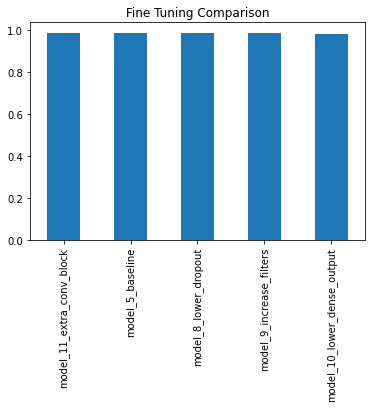

In [ ]:
fine_tuning_acc.sort_values(ascending=False).plot(kind="bar", title="Fine Tuning Comparison")

So the hyperparameters were fine for the most part, just adding another convolutional block increased accuracy just a bit. So we'll go with that model, model 11.

### Construct the final model with tuned hyperparameters

In [ ]:
final_model = model_10
final_model.evaluate(val_ds)

262/262 [==============================] - 1s 5ms/step - loss: 0.0453 - accuracy: 0.9858


[0.045344505459070206, 0.9858062863349915]

So we'd expect around a 98.6% accuracy rate on the csv uploaded to Kaggle.

## Evaluate Test Dataset

In [ ]:
test_preds = tf.round(final_model.predict(test_df))
test_preds

875/875 [==============================] - 2s 2ms/step


<tf.Tensor: shape=(28000, 10), dtype=float32, numpy=
array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
test_preds_labels = tf.argmax(test_preds, axis=1)
test_preds_labels_df = pd.DataFrame(test_preds_labels)
test_preds_labels_df

,0
0,2
1,0
2,9
3,9
4,3
...,...
27995,9
27996,7
27997,3
27998,9


In [ ]:
test_df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(len(np.arange(1, 28001)), len(test_preds_labels))
numpy_predicts = {"ImageId": np.arange(1, 28001), "Label":test_preds_labels}
predict_df = pd.DataFrame(numpy_predicts)
predict_df.to_csv("prediction_1.csv", index=False)

28000 28000
